In [22]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from experiment.v1dd_em_client import V1DDEMClient
from analysis_tools import set_stylesheet
set_stylesheet()
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
client = V1DDEMClient()

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


Reference notebook: https://github.com/AllenInstitute/swdb_2022/blob/main/DynamicBrain/EM_reference_Materials/EM_Meshwork_Creation.ipynb

In [21]:
from meshparty import meshwork
from meshparty import skeleton_io
from meshparty.skeleton import Skeleton
import pcg_skel

In [433]:
def load_neuron_meshwork(root_id):
    root_point, root_point_res = client.get_single_soma_position(root_id, return_voxel_resolution=True)

    mw = pcg_skel.coord_space_meshwork(
        root_id=root_id,
        client=client.cave_client,
        root_point=root_point,
        root_point_resolution=root_point_res,
        collapse_soma=True,
        synapses="all",
        synapse_table=client.synapse_table,
    )

    # Correct the synapse voxel resolutions
    for syn in ("pre_syn", "post_syn"):
        mw.anno[syn].voxel_resolution = client.get_voxel_res(mw.anno[syn].data_original)

    return mw

In [372]:
axo_proof = client.get_axon_proofreading_table()
den_proof = client.get_dendrite_proofreading_table()
axo_proof = axo_proof[axo_proof.cell_type.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)]
den_proof = den_proof[den_proof.cell_type.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)]

pd.merge(axo_proof, den_proof, how="inner", on="pt_root_id", suffixes=("__axo", "__den"))

,index__axo,id__axo,valid__axo,classification_system__axo,cell_type__axo,pt_supervoxel_id__axo,pt_root_id,pt_position__axo,index__den,id__den,valid__den,classification_system__den,cell_type__den,pt_supervoxel_id__den,pt_position__den
0,2,3,t,ariadne_axon_proofreading,accepted,91421987876227203,864691132806367265,"[85857, 68426, 9515]",408,2359,t,ariadne_dendrite_pf,allen_qa,91421712998210089,"[85966, 67383, 9409]"
1,3,4,t,ariadne_axon_proofreading,accepted,86492327157525518,864691133028846290,"[66650, 52945, 6945]",532,2365,t,ariadne_dendrite_pf,allen_qa,86491777401519134,"[66487, 50633, 6781]"
2,5,6,t,ariadne_axon_proofreading,ariadne_qa,94730486547008902,864691132616611290,"[98834, 73085, 5610]",502,2375,t,ariadne_dendrite_pf,allen_qa,94589199302814020,"[98421, 70793, 5564]"
3,7,8,t,ariadne_axon_proofreading,ariadne_qa,91838908337575741,864691132686850954,"[87580, 47143, 4900]",469,2389,t,ariadne_dendrite_pf,allen_qa,91980745337638949,"[87996, 51617, 4948]"
4,8,9,t,ariadne_axon_proofreading,accepted,88258280471811747,864691132653518844,"[73467, 79980, 8278]",492,2352,t,ariadne_dendrite_pf,allen_qa,88258417844086217,"[73539, 80463, 8145]"
5,9,10,t,ariadne_axon_proofreading,ariadne_qa,88110877194327876,864691132728010624,"[73026, 53222, 8351]",354,2368,t,ariadne_dendrite_pf,allen_qa,88251408524121765,"[73321, 52406, 8270]"
6,12,13,t,ariadne_axon_proofreading,ariadne_qa,95852812974099989,864691132760375604,"[103287, 58751, 5134]",1670,2397,t,ariadne_dendrite_pf,allen_qa,95782512949262887,"[103018, 59157, 5052]"


In [376]:
table = client.get_cell_type_table()
table = table[(table.axon_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)) & (table.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE))]
table.head()

,index,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,position_microns,axon_proofreading_status,dendrite_proofreading_status
809,809,819,t,265430,coarse_manual,BPC,265430,t,221.014158,91980814057135773,864691132686850954,"[793926, 465833, 223380]","[789968, 460556, 23615]","[797883, 470954, 24434]","[-113.85461191849143, 230.8467817383433, -321....",ariadne_qa,allen_qa
1621,1622,1314,t,351773,coarse_manual,PYC,351773,t,338.737007,95852812974037233,864691132760375604,"[929338, 528534, 228870]","[925225, 523800, 24182]","[933683, 533112, 25186]","[21.863739331515973, 292.05435805485354, -332....",ariadne_qa,allen_qa
2883,2887,217,t,294076,coarse_manual,PYC,294076,t,288.971677,94589268022183959,864691132616611290,"[885416, 641054, 246735]","[881148, 636863, 26054]","[889839, 645166, 27058]","[-21.494266946783174, 405.4674876682663, -345....",ariadne_qa,allen_qa


In [434]:
# root_id = client.get_2p_corresponded_table().pt_root_id.iloc[0]
# root_id = 864691132806367265 # proofreading
# root_id = 864691132686850954 # proofread BPC
root_id = 864691132760375604 # proofread PYC

# TODO: Look at this cell
root_id = 864691132562619342 # MC with proofread dendrites and a lot of 2P corresponded inputs

print(root_id)
mw = load_neuron_meshwork(root_id)

864691132562619342


100%|██████████| 20963/20963 [00:02<00:00, 8066.64it/s] 


In [390]:
from meshparty.meshwork.meshwork import Meshwork

Text(0.5, 1.0, '864691132760375604')

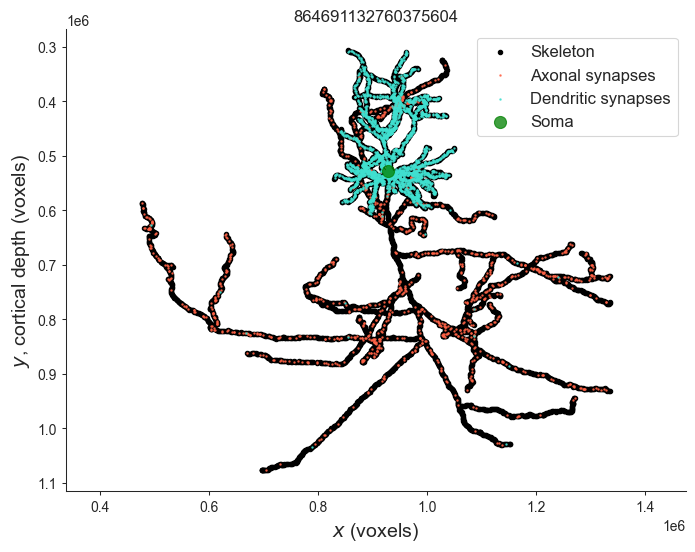

In [412]:
# Plot the mesh without any transformation
x, y = 0, 1
s_skeleton = 10
s_synapse = 1

plt.figure(figsize=(8, 6))

# Skeleton
plt.scatter(mw.skeleton.vertices[:, x], mw.skeleton.vertices[:, y], s=s_skeleton, color="black", label="Skeleton")

# Synapses
plt.scatter(mw.anno.pre_syn.points[:, x], mw.anno.pre_syn.points[:, y], s=s_synapse, color="tomato", alpha=0.75, label="Axonal synapses")
plt.scatter(mw.anno.post_syn.points[:, x], mw.anno.post_syn.points[:, y], s=s_synapse, color="turquoise", alpha=0.75, label="Dendritic synapses")

# Soma
plt.scatter(mw.skeleton.vertices[mw.skeleton.root, x], mw.skeleton.vertices[mw.skeleton.root, y], color="green", s=75, alpha=0.75, label="Soma")

# Formatting
plt.gca().invert_yaxis() # Open down
plt.legend(fontsize=12)
plt.xlabel("$x$ (voxels)", fontsize=14)
plt.ylabel("$y$, cortical depth (voxels)", fontsize=14)
plt.axis("equal")
plt.title(root_id)

In [465]:
mw.anno.pre_syn.points[:, (0, 1)] + (0, 1)

array([[968254. , 586569.7],
       [932684.1, 616319.6],
       [876104. , 608094. ],
       ...,
       [932412.5, 646845.5],
       [906368. , 580390.8],
       [672927.8, 561504.9]])

Text(0.5, 1.0, '864691132562619342')

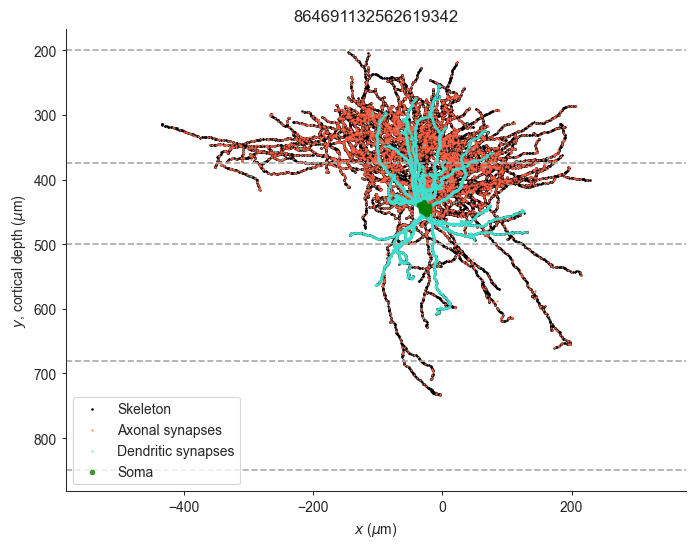

In [461]:
# Plot the mesh with microns transformation
x, y = 0, 1
s_skeleton = 1
s_synapse = 1/2

def data_transform(data, x=0, y=1):
    data = client.transform_nm_to_microns.apply(data)
    return data[:, x], data[:, y]

plt.figure(figsize=(8, 6))

# Skeleton
plt.scatter(*data_transform(mw.skeleton.vertices, x, y), s=s_skeleton, color="black", label="Skeleton")

# Synapses
plt.scatter(*data_transform(mw.anno.pre_syn.points, x, y), s=s_synapse, color="tomato", alpha=0.75, label="Axonal synapses")
plt.scatter(*data_transform(mw.anno.post_syn.points, x, y), s=s_synapse, color="turquoise", alpha=0.75, label="Dendritic synapses")

# Soma
# plt.scatter(*data_transform(mw.skeleton.vertices[mw.skeleton.root], x, y), color="green", s=75, alpha=0.75, label="Soma")
plt.scatter(*data_transform(mw.mesh.vertices[mw.root_region], x, y), color="green", s=10, alpha=0.75, label="Soma")

# Plot layer boundaries
for depth in V1DDEMClient.LAYER_BOUNDARIES:
    plt.axhline(depth, color="darkgray", linestyle="dashed")

plt.gca().invert_yaxis() # Open down
plt.legend()
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$, cortical depth ($\mu$m)")
plt.axis("equal")
plt.title(root_id)

In [444]:
mw.skeleton.path_to_root(572)

JointSkeletonIndex([  572,   587,   604,   617,   618,   633,   650,
                      665,   678,   691,   706,   725,   737,   752,
                      769,   768,   783,   806,   826,   846,   864,
                      890,   925,   951,   973,   994,  1018,  1019,
                     1020,  1046,  1073,  1116,  1158,  1159,  1194,
                     1228,  1273,  1318,  1366,  1426,  1486,  1559,
                     1617,  1686,  1688,  1745,  1805,  1880,  1978,
                     2077,  2189,  2318,  2321,  2320,  2443,  2547,
                     2640,  2646,  2742,  2853,  2855,  2966,  3072,
                     3190,  3284,  3388,  3517,  3648,  3785,  3943,
                     4057,  4171,  4314,  4318,  4465,  4645,  4646,
                     4834,  4836,  4995,  4997,  5145,  5146,  5301,
                     5302,  5466,  5661,  5824,  6013,  6204,  6407,
                     6604,  6779,  6773,  6970,  6964,  6957,  6958,
                     7165,  7162, 

Path to rand axonal syn neurite dist: 146.17 µm (straight-line dist: 107.50 µm)
Path to rand dendritic syn neurite dist: 209.52 µm (straight-line dist: 162.03 µm)


Text(0.5, 1.0, '864691132562619342')

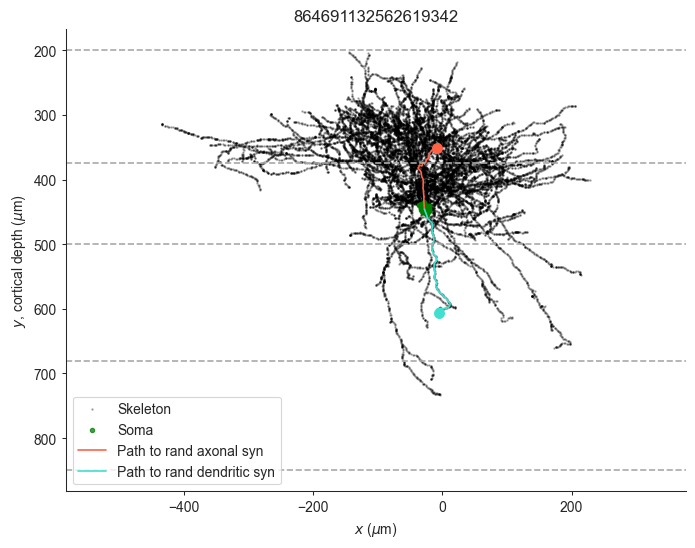

In [459]:
import random
from meshparty.meshwork.meshwork import Meshwork

# Plot the mesh with microns transformation
s_skeleton = 1
s_synapse = 1

plt.figure(figsize=(8, 6))
plt.scatter(*data_transform(mw.mesh.vertices, x, y), s=s_skeleton, alpha=0.25, color="black", label="Skeleton")
# plt.scatter(mw.mesh.vertices[:, x] / 1000, mw.mesh.vertices[:, y] / 1000, s=s_skeleton, color="green", label="Skeleton")
# plt.scatter(*data_transform(mw.anno.pre_syn.points, x, y), s=s_synapse, color="tomato", alpha=0.75, label="Axonal synapses")
# plt.scatter(*data_transform(mw.anno.post_syn.points, x, y), s=s_synapse, color="turquoise"| alpha=0.75, label="Dendritic synapses")
# plt.scatter(*data_transform(mw.skeleton.vertices[mw.skeleton.root], x, y), color="green", s=75, alpha=0.75, label="Soma")
plt.scatter(*data_transform(mw.mesh.vertices[mw.root_region], x, y), color="green", s=10, alpha=0.75, label="Soma")

def plot_path_to_root(skel_idx, **kwargs):
    # path_skel_indices = mw.skeleton.path_between(start_skel_idx, end_skel_idx) # Computes shortest path using Dijkstra algorithm
    path_skel_indices = mw.skeleton.path_to_root(skel_idx)
    path_positions = mw.skeleton.vertices[path_skel_indices] # Vertices are in nm units
    path_positions_microns = client.transform_position_to_microns(path_positions)

    # NOTE: Path length can also be computed as the length of individual line segments in path_positions_microns
    # However, the V1DD transform does not involve any warping (only translation and rotation), so using path_length is fine.
    # Source: https://github.com/ceesem/standard_transform/blob/main/standard_transform/datasets.py#L18
    
    path_length_microns = mw.skeleton.distance_to_root[skel_idx] / 1000
    path_length_microns = mw.skeleton.path_length(path_skel_indices) / 1000 # Another way of computing path length (same result)

    plt.plot(path_positions_microns[:, x], path_positions_microns[:, y], **kwargs) # Plot path
    plt.scatter(path_positions_microns[0, x], path_positions_microns[0, y], color=kwargs["color"], s=50) # Plot start point

    straight_line_length = np.linalg.norm(path_positions_microns[0] - path_positions_microns[-1])
    print(f"{kwargs['label']} neurite dist: {path_length_microns:.2f} µm (straight-line dist: {straight_line_length:.2f} µm)")

# soma_skel_idx = mw.skeleton.root
plot_path_to_root(random.choice(mw.anno.pre_syn.skel_index), color="tomato", label="Path to rand axonal syn")
plot_path_to_root(random.choice(mw.anno.post_syn.skel_index), color="turquoise", label="Path to rand dendritic syn")

# Plot layer boundaries
for depth in V1DDEMClient.LAYER_BOUNDARIES:
    plt.axhline(depth, color="darkgray", linestyle="dashed")

plt.gca().invert_yaxis() # Open down
plt.legend()
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$, cortical depth ($\mu$m)")
plt.axis("equal")
plt.title(root_id)


In [314]:
# This function will make it easy to check our work as we go.
def simple_neuron_plot(nrn, projection='xy', color='k', vertices='skeleton', synapses=False, highlight_root=False):
    """
    Parameters:
    nrn : meshwork object
    projection : one of "xy", "yz", or "zx" determining which projection to show in the simple plot
    color : matplotlib-accepted color value
    vertices : one of "skeleton" or "mesh" to determine which values are shown. Skeleton is default.
    synapses : True to show both pre and post, False to show neither, and "pre" or "post" to show only pre or post respectively.
    highlight_root : boolean. True if you want to show the root vertices with a big red dot.
    """
    if projection=='xy' or projection=="yx":
        ind = (0, 1)
        flip = True
    elif projection == 'yz' or projection == "zy":
        ind = (2, 1)
        flip = True
    elif projection == 'zx' or projection == "xz":
        ind = (0, 2)
        flip = False
    else:
        raise ValueError('Projection must be one of "xy", "yz", or "zx"')
        
    fig, ax = plt.subplots(figsize=(4,4))
    if vertices == "skeleton":
        v1 = nrn.skeleton.vertices[:,ind[0]]
        v2 = nrn.skeleton.vertices[:,ind[1]]
        rid = nrn.skeleton.root
    elif vertices == "mesh":
        v1 = nrn.mesh.vertices[:,ind[0]]
        v2 = nrn.mesh.vertices[:,ind[1]]
        rid = nrn.root_region
    else:
        raise ValueError('vertices must be one of "skeleton" or "mesh"')

    ax.scatter(
        v1,
        v2,
        s=1,
        color=color,
    )

    
    if synapses:
        # syn_res = [9.7, 9.7, 45.0]

        try:
            v1_pre = nrn.anno.pre_syn.points[:,ind[0]]
            v2_pre = nrn.anno.pre_syn.points[:,ind[1]]
            v1_post = nrn.anno.post_syn.points[:,ind[0]]
            v2_post = nrn.anno.post_syn.points[:,ind[1]]

            # v1_pre *= syn_res[ind1]
            # v1_post *= syn_res[ind1]
            # v2_pre *= syn_res[ind2]
            # v2_post *= syn_res[ind2]
        except:
            v1_pre = []
            v1_post = []
            v2_pre = []
            v2_post = []
        if synapses == True or synapses == 'pre':
            ax.scatter(
                v1_pre,
                v2_pre,
                s=2,
                color='tomato',
                alpha=0.7,
            )
        if synapses == True or synapses == "post":
            ax.scatter(
                v1_post,
                v2_post,
                s=2,
                color='turquoise',
                alpha=0.2,
            )
            
    if highlight_root:
        ax.scatter(
            v1[rid],
            v2[rid],
            s=25,
            color='violet',
        )

    ax.set_aspect('equal')
    if flip:
        ax.invert_yaxis()
    return fig, ax

In [6]:
client.get_tables()

['ariadne_axon_task',
 'correspondance_pilot',
 'ariadne_multisoma_proofreading_v1',
 'ariadne_dendrite_proofreading_v2',
 'ariadne_axon_proofreading_v1',
 'synapses_v1dd',
 'multisoma_split_task',
 'ariadne_dendrite_task',
 'ophys_examples',
 'manual_central_types',
 'nucleus_detection_v0']

In [7]:
client.get_2p_corresponded_table().head()

,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,0,91,t,session13,plane2_0032,92618530666908453,864691132735860016,"[90593, 69633, 3833]"
1,1,90,t,session13,plane2_014,92055099945608124,864691132710145793,"[88274, 67650, 5900]"
2,2,55,t,session13,plane0_roi_0060,93180175218572599,864691132760377194,"[92791, 64340, 5745]"
3,3,43,t,session13,plane1_roi_0030,91843650048621008,864691132720617684,"[87483, 66110, 5411]"
4,4,98,t,session13,plane0_0067,94939531261931905,864691132801571037,"[99750, 64882, 5727]"


In [8]:
root_id = 864691132735860016

In [84]:
cv = client.cave_client.info.segmentation_cloudvolume(progress=False)
cv

In [97]:
client.cave_client.chunkedgraph

In [99]:
cv.skeleton.get(1)

SkeletonDecodeError: File(s) do not exist: skeletons/1

In [9]:
# Create meshwork object
mw = pcg_skel.coord_space_meshwork(
    root_id=root_id,
    client=client.cave_client
)

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/caveclient/l2cache.py:78: UserWarning: L2Cache is in an experimental stage
  warnings.warn("L2Cache is in an experimental stage", UserWarning)
100%|██████████| 5947/5947 [00:00<00:00, 46171.62it/s]


(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

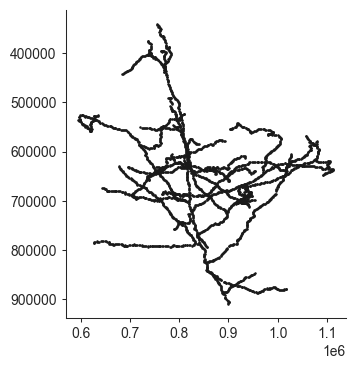

In [10]:
simple_neuron_plot(mw)

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

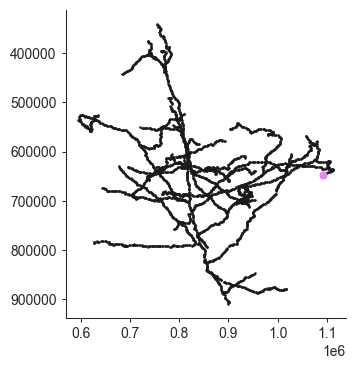

In [11]:
simple_neuron_plot(mw, highlight_root=True)

Note that the root (pink dot) is not in the location we would expect, at the soma.

## Building a meshwork with additional properties
   
The <code>coord_space_meshwork</code> has a number of parameters which allow us to create a richer file, for example with the root at the cell body and synapses added to the data. Here, we'll cover the ones that you might want to use here.

<table style="float: left;">
    <tr>
        <td><h2>Parameter</h2></td>
        <td><h2>Description</h2></td>
    </tr> 
    <tr>
        <td>root_id</td>
        <td>Root id of the neuron to skeletonize</td>
    </tr>
    <tr>
        <td>client</td>
        <td>A caveclient initialized with the `minnie_public_v343` datastack, as above</td>
    </tr>
    <tr>
        <td>root_point</td>
        <td>If specified, the closest vertex to this point will be set as root. If not specified, a random end point will be chosen.</td>
    </tr>
    <tr>
        <td>root_point_resolution</td>
        <td>The resolution in nm/voxel that the root point is specified in. If you are using neuroglancer or annotation tables, this value is [4,4,40].</td>
    </tr> 
    <tr>
        <td>collapse_soma</td>
        <td>If set to True, collapses all mesh vertices within collapse_radius into a single root vertex at the location given in <code>root_point</code>. If you are specifying a root point that corresponds to a cell body, set this to True.</td>
    </tr>
    <tr>
        <td>collapse_radius</td>
        <td>Vertices within this radius are collapsed into the root vertex. The default value, 7500 nm, is a good general radius size.</td>
    </tr>
    <tr>
        <td>synapses</td>
        <td>'pre', 'post', 'all', or None. If pre, there will be an attempt to look up the presynaptic synapses on this neuron's root id. The table used to look this information up is specified in the next parameter - synapse table. The resulting table will be saved as an annotation on this meshwork object under the name 'pre_syn'. If argument is 'post', the same will be done but for postsynaptic sites. 'all' will look up and add annotation tables for both pre and postsynaptic sites. </td>
    </tr>
    <tr>
        <td>synapse_table</td>
        <td>The CAVEclient annotation table from which the synapses will be queried. For this dataset, use <code>synapses_pni_2</code>. </td>
    </tr>
    <tr>
        <td>remove_self_synapse</td>
        <td>True by default. If True, synapses where the pre- and post-synaptic root ids are the same are ignored. Most of the time, this occures due to errors in synapse prediction or segmentation, but such biological autapses are possible and are omitted as well.</td>
    </tr>
</table>


## Let's create another meshwork with synapses included and with the root_point set to the soma location

Here we will use the neuron in the 5th row of our dataframe containing information on our Bipolar Cells. 
We need to use the data in the pt_root_id column and the pt_position (soma position). You could also get the root location from a point in Neuroglancer.

In [12]:
corresponded_table = client.get_2p_corresponded_table()
i = 0
root_id = corresponded_table.at[i, "pt_root_id"]
soma_location = corresponded_table.at[i, "pt_position"]

mw_2 = pcg_skel.coord_space_meshwork(
    root_id=root_id,
    client=client.cave_client,
    root_point=soma_location,
    root_point_resolution=client.get_voxel_res(corresponded_table),
    collapse_soma=True,
    synapses="all",
    synapse_table=client.synapse_table,
)

100%|██████████| 5947/5947 [00:00<00:00, 47897.12it/s]


(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

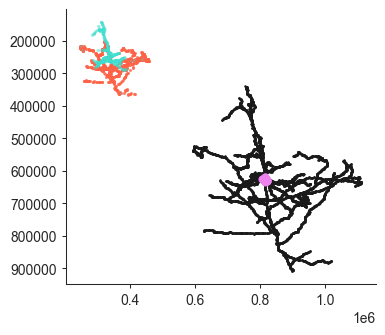

In [29]:
simple_neuron_plot(mw_2, highlight_root=True, synapses=True, vertices="mesh")

In [20]:
with mw_2.mask_context(~mw_2.anno.is_axon.mesh_mask):
    simple_neuron_plot(mw_2, synapses=True, highlight_root=True)


AttributeError: 'AnchoredAnnotationManager' object has no attribute 'is_axon'

100%|██████████| 8878/8878 [00:00<00:00, 49131.40it/s]


(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

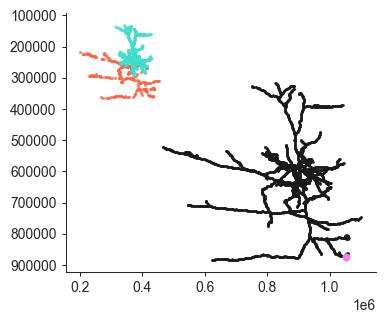

In [26]:
i = 4
root_id = corresponded_table.at[i, "pt_root_id"]
soma_location = corresponded_table.at[i, "pt_position"]

mw_3 = pcg_skel.coord_space_meshwork(
    root_id=root_id,
    client=client.cave_client,
    # root_point=soma_location,
    # root_point_resolution=client.get_voxel_res(corresponded_table),
    # collapse_soma=True,
    synapses="all",
    synapse_table=client.synapse_table,
)
simple_neuron_plot(mw_3, synapses=True, highlight_root=True)